# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


Chuyenmt


# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data):
    #Tamaño completo de la data osea el numero de puntos que tiene la grabacion a una frecuencia de 360Hz por segundo ejemplo sujeto 101 tiene 650000 puntos
    #Creamos el objeto wavelet para poder aplicar la trasnformada wavelet
    w = pywt.Wavelet('sym4') 
    
    #Sacamos el nivel maximo de descomposicion que se puede hacer con la data que tenemos dec_len es el tamaño del filtro de descomposicion (2N) donde N es el orden del filtro Sym4 es orden 4
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.05 
    
    #Desccomponemos los datos en los coeficientes de la wavelet en el caso del paciente 101 tenemos 16 niveles de descomposicion 
    coeffs = pywt.wavedec(data, 'sym4', level=maxlev) 

    for i in range(1, len(coeffs)):
        #Aplicamos el umbral a los coeficientes de la wavelet donde el umbral es el 5% del valor maximo de los coeficientes en el sujeto 101 el valor maximo fue de  1000 con esto, se le resta a cada dato del coeficiente 
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) 
    #Se reconstrue la data con los coeficientes modificados     
    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec


# Variables Definitions

In [30]:
path = 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
print(classes.index('A'))
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

3


In [5]:
count_classes

[0, 0, 0, 0, 0]

# Prepere Input Files

In [6]:
# Read files
filenames = next(os.walk(path))[2] # Usando os.walk() para obtener la lista de todos los archivos en el directorio especificado por la variable path. [2] simplemente devuelve la lista de nombres de los archivos en ese directorio.

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
filenames

['100.csv',
 '100annotations.txt',
 '101.csv',
 '101annotations.txt',
 '102.csv',
 '102annotations.txt',
 '103.csv',
 '103annotations.txt',
 '104.csv',
 '104annotations.txt',
 '105.csv',
 '105annotations.txt',
 '106.csv',
 '106annotations.txt',
 '107.csv',
 '107annotations.txt',
 '108.csv',
 '108annotations.txt',
 '109.csv',
 '109annotations.txt',
 '111.csv',
 '111annotations.txt',
 '112.csv',
 '112annotations.txt',
 '113.csv',
 '113annotations.txt',
 '114.csv',
 '114annotations.txt',
 '115.csv',
 '115annotations.txt',
 '116.csv',
 '116annotations.txt',
 '117.csv',
 '117annotations.txt',
 '118.csv',
 '118annotations.txt',
 '119.csv',
 '119annotations.txt',
 '121.csv',
 '121annotations.txt',
 '122.csv',
 '122annotations.txt',
 '123.csv',
 '123annotations.txt',
 '124.csv',
 '124annotations.txt',
 '200.csv',
 '200annotations.txt',
 '201.csv',
 '201annotations.txt',
 '202.csv',
 '202annotations.txt',
 '203.csv',
 '203annotations.txt',
 '205.csv',
 '205annotations.txt',
 '207.csv',
 '207ann

In [8]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f) # os.path.splitext() divide la ruta en una tupla que contiene el nombre del archivo y la extensión del archivo.
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)
    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
annotations

['C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\100annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\101annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\102annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\103annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\104annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\105annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\106annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\107annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\108annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\109annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\111annotations.txt',
 'C:\\Users\\Sistemas\\Desktop\\

In [10]:
records

['C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\100.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\101.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\102.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\103.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\104.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\105.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\106.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\107.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\108.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\109.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\111.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\112.csv',
 'C:\\Users\\Sistemas\\Desktop\\Arrhythmia_model\\mitbih_database\\113.csv',

# Data Extraction and Preprocessing

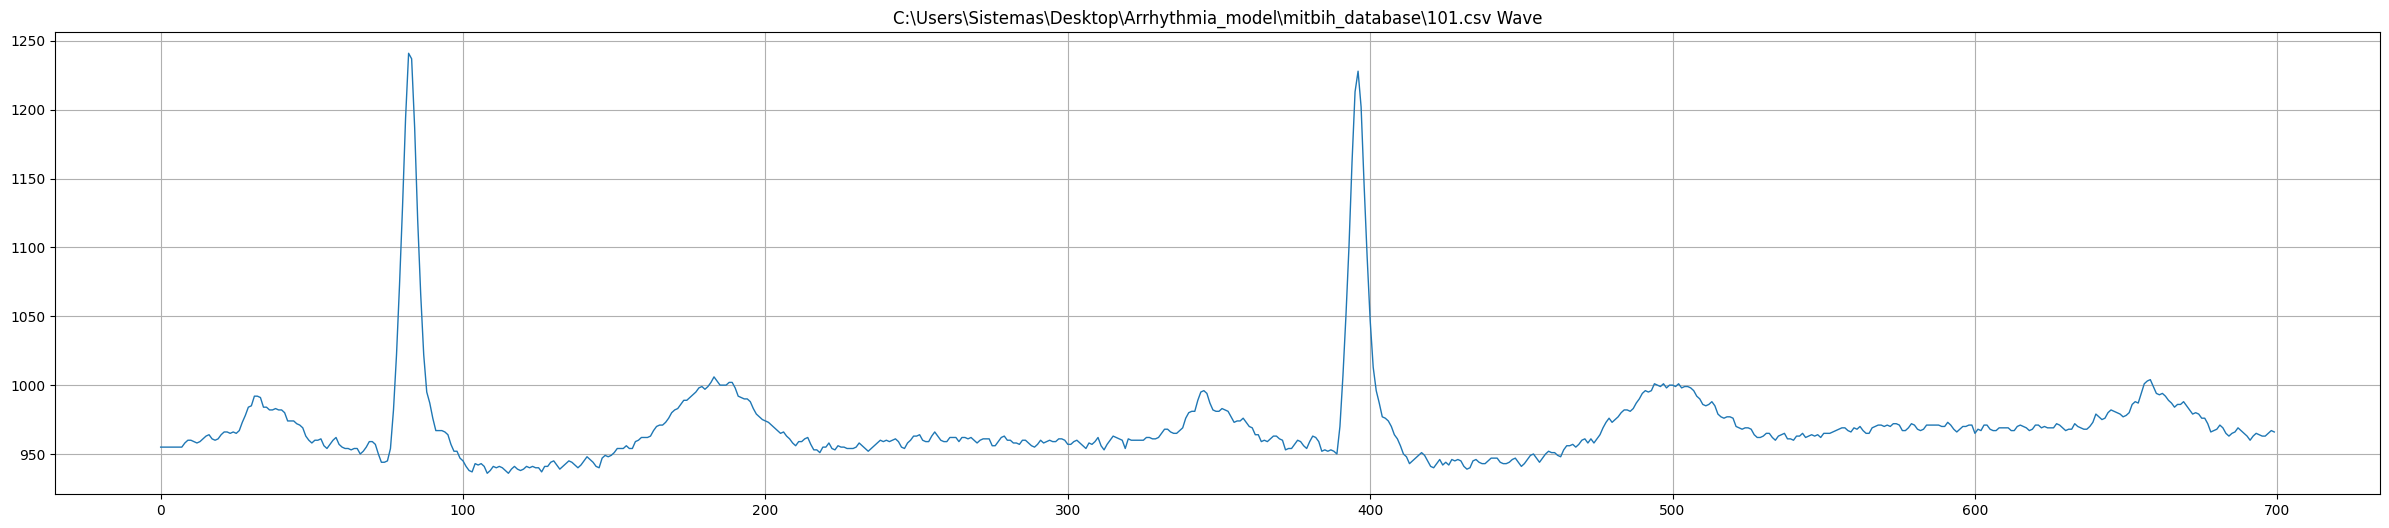

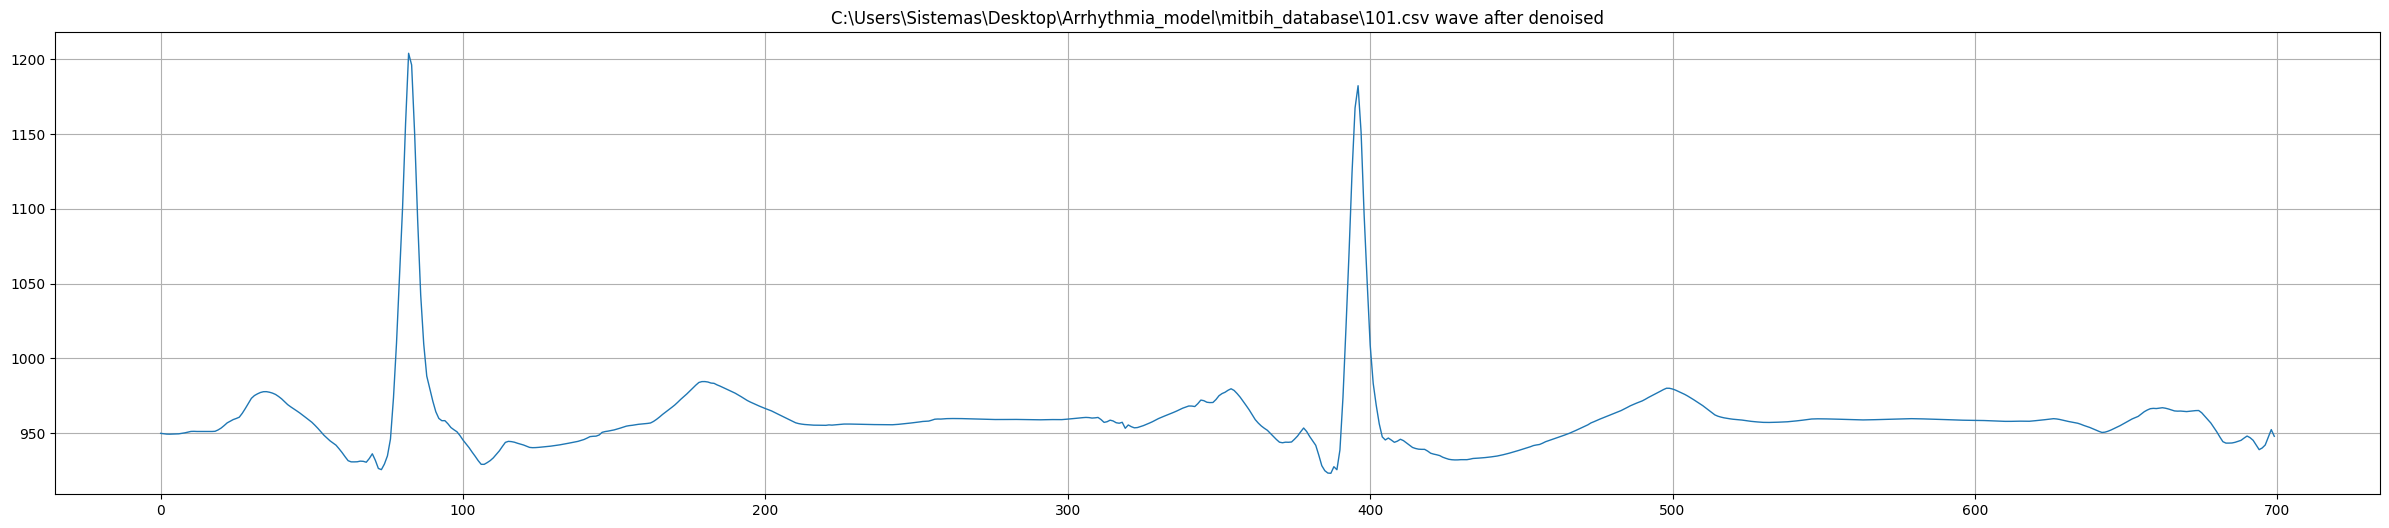

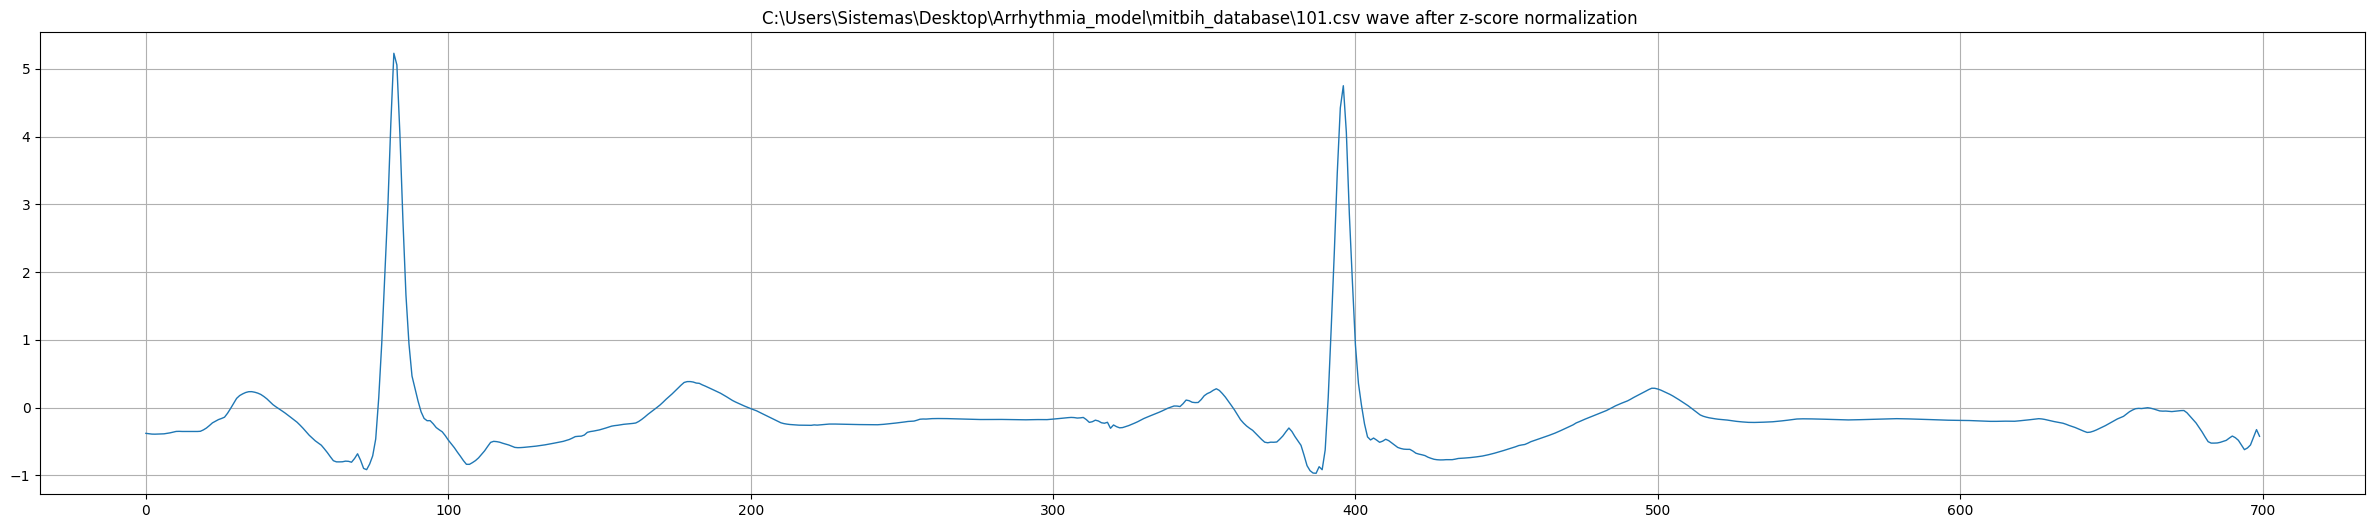

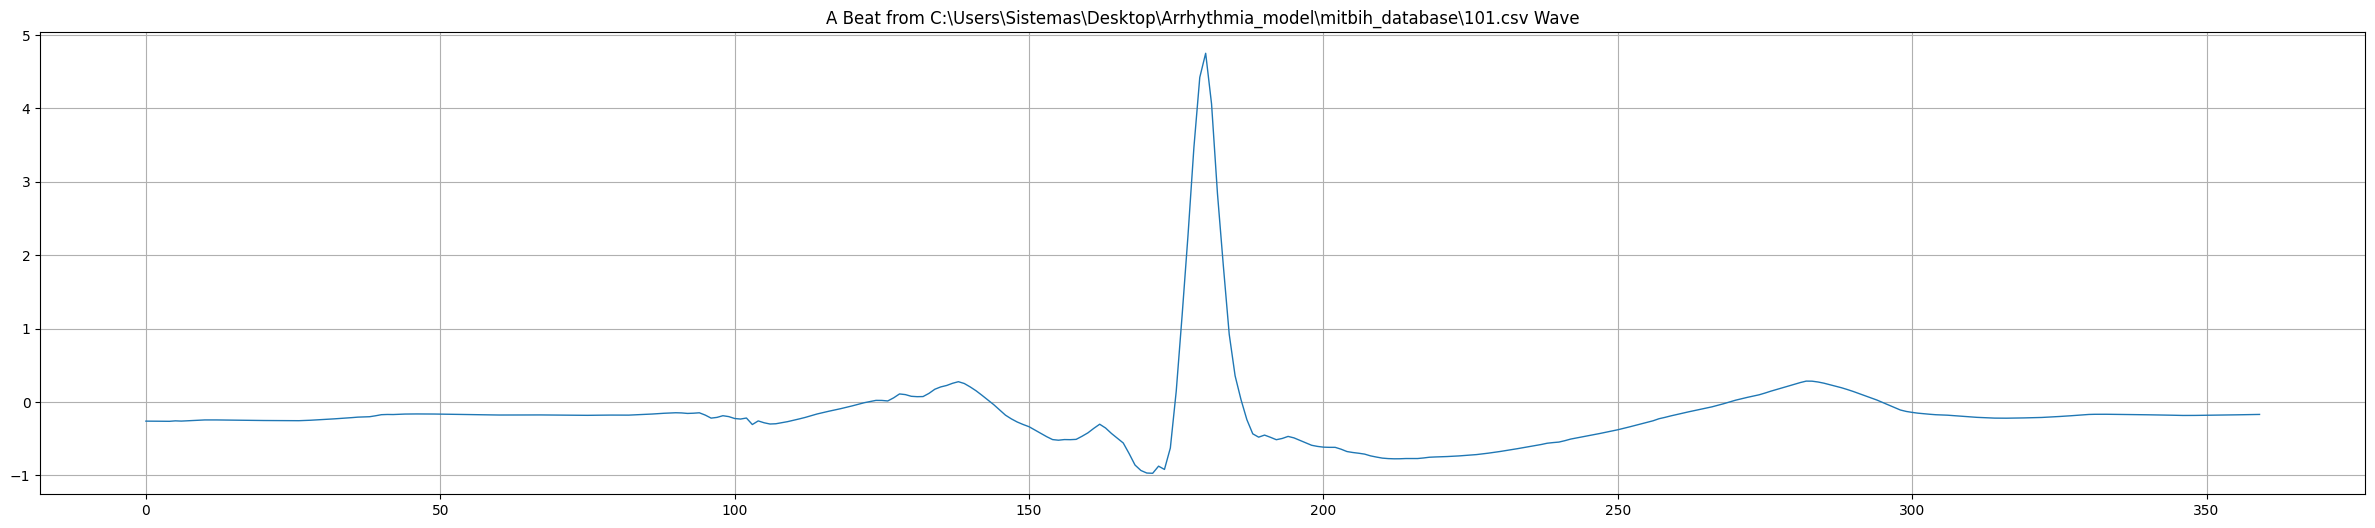

(100012, 360) (100012,)


In [31]:
# Records
for r in range(0,len(records)):
    signals = [] # Lista para almacenar las señales de los pacientes

    with open(records[r], 'rt') as csvfile: # Abrir el archivo csv en modo de lectura de texto
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # csv.reader() lee las líneas del archivo csv dado
        
        row_index = -1
        for row in spamreader:
            if(row_index >= 0): # Ignorar la primera fila que es donde se encuentran los nombres de las columnas
                signals.insert(row_index, int(row[1])) # row[1] es la columna de la señal. Solo tomamos la medida MLII de la señal
            row_index += 1

    # Inicio de la graficas de señales
            
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)

    # Plot an example to the signals after denoised 
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals after z-score normalization
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Fin de grafias de señales
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):

                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    

                    X.append(beat)
                    y.append(arrhythmia_index)
                    
                    
                    

# data shape
print(np.shape(X), np.shape(y))


In [32]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


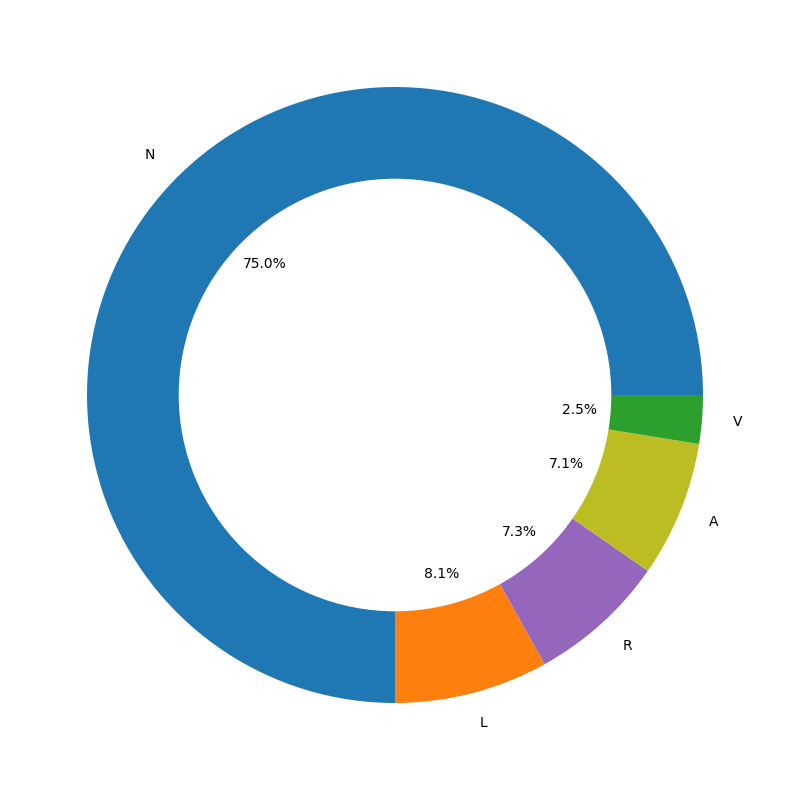

In [35]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [53]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]

df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=False,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=False,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=False,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


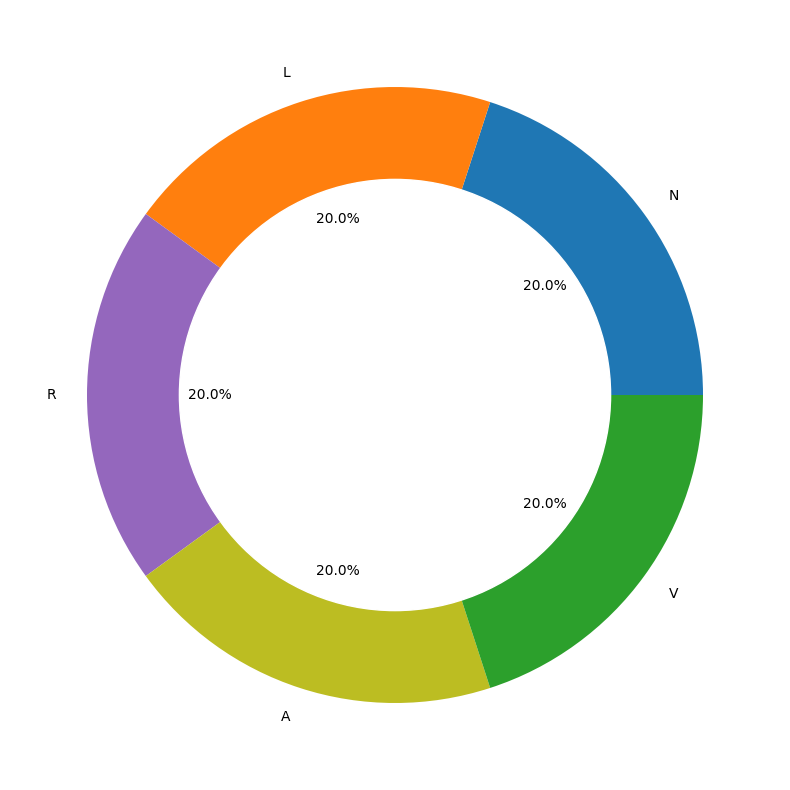

In [54]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [28]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [29]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [30]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [19]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

c:\Users\Sistemas\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 16)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 32)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 89, 64)         │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 44, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 128)        │       155,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 21, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │        94,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,887 (1.12 MB)

 Trainable params: 292,887 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Fitting the model

In [21]:
history = model.fit(train_x, train_y, batch_size=36, epochs=30, verbose=1, validation_data=(test_x, test_y))

Epoch 1/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7974 - loss: 0.5485 - val_accuracy: 0.9600 - val_loss: 0.1333
Epoch 2/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9516 - loss: 0.1553 - val_accuracy: 0.9638 - val_loss: 0.1309
Epoch 3/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9677 - loss: 0.1120 - val_accuracy: 0.9734 - val_loss: 0.0885
Epoch 4/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9726 - loss: 0.0975 - val_accuracy: 0.9806 - val_loss: 0.0758
Epoch 5/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9769 - loss: 0.0821 - val_accuracy: 0.9820 - val_loss: 0.0680
Epoch 6/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9782 - loss: 0.0797 - val_accuracy: 0.9820 - val_loss: 0.0747
Epoch 7/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9827 - loss: 0.0683 - val_accuracy: 0.9826 - val_loss: 0.0687
Epoch 8/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9830 - loss: 0.0649 - val_accu

**Plotting the loss convergence**

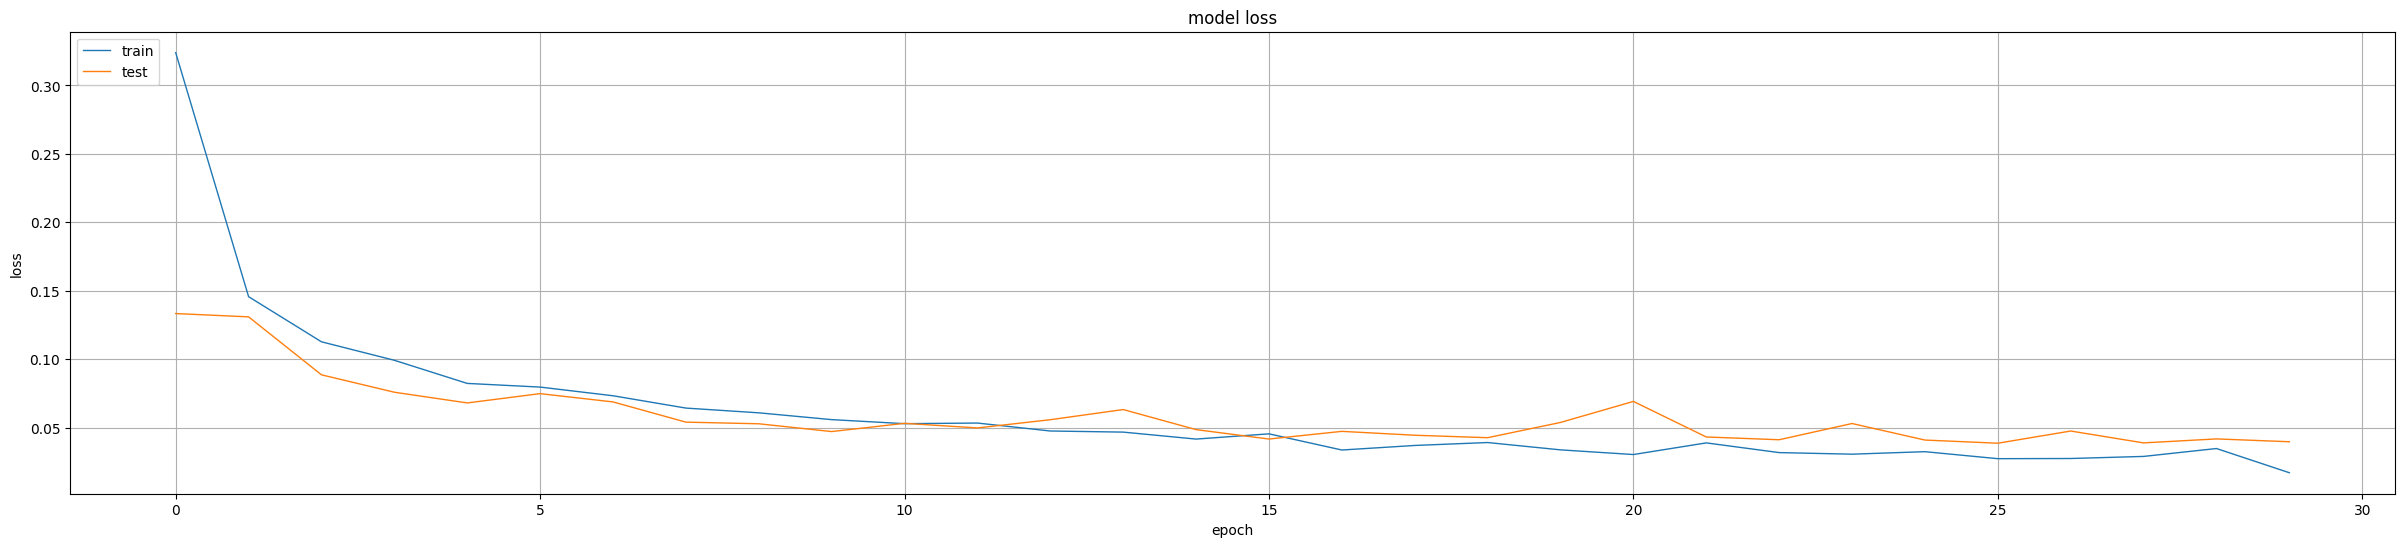

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

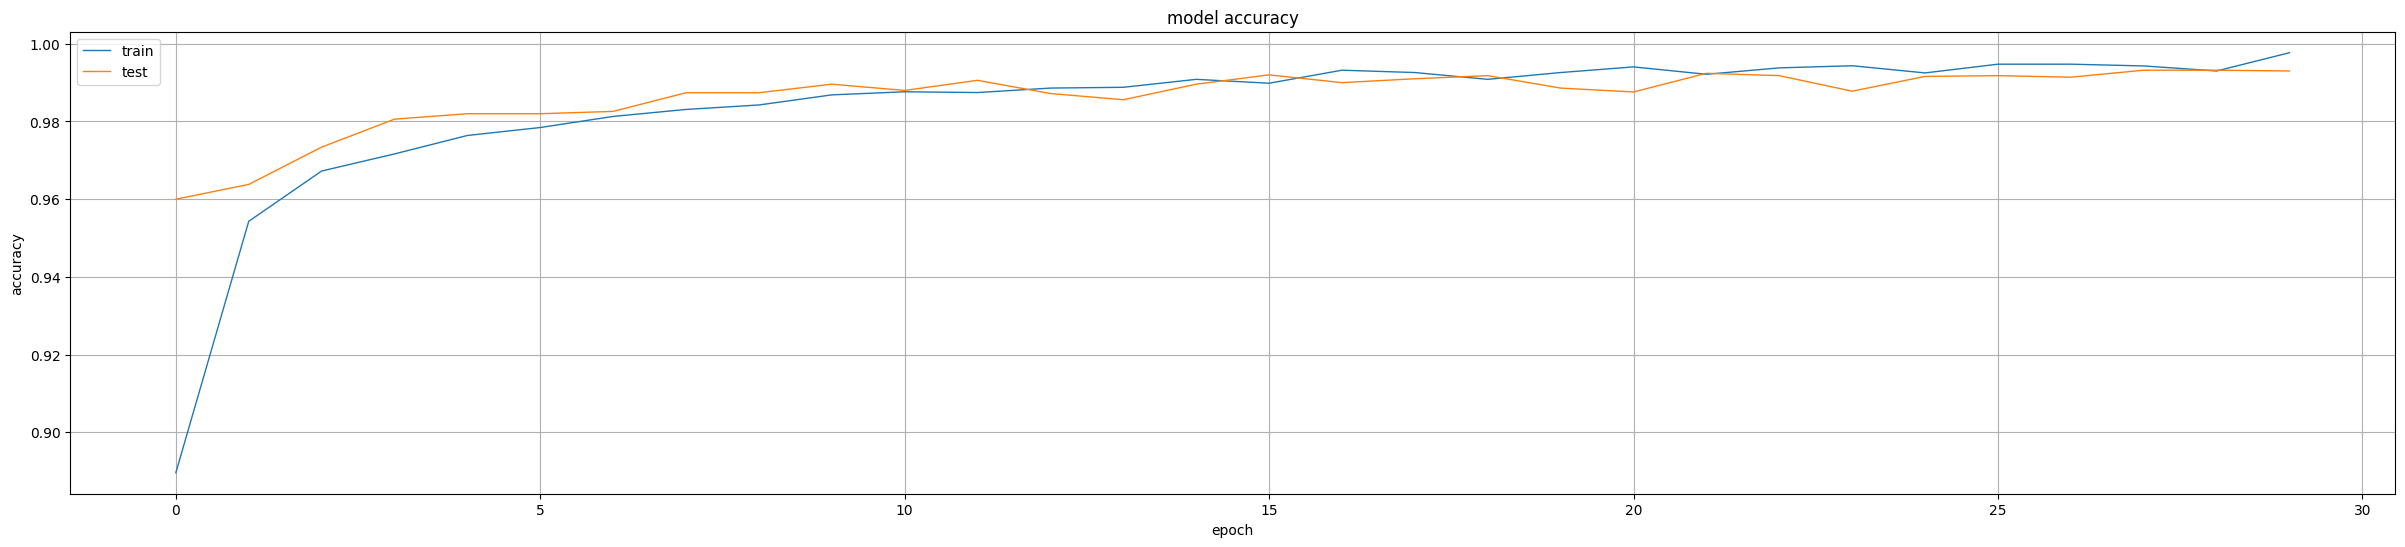

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [24]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0397
Test Loss: 0.04171062633395195
Test accuracy: 0.9929999709129333


In [25]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_x)
y_true = test_y.astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [26]:
print(np.argmax(y_pred, axis=1))
print(np.argmax(y_true, axis=1))


[1 3 3 ... 4 3 0]
[1 3 3 ... 4 3 0]


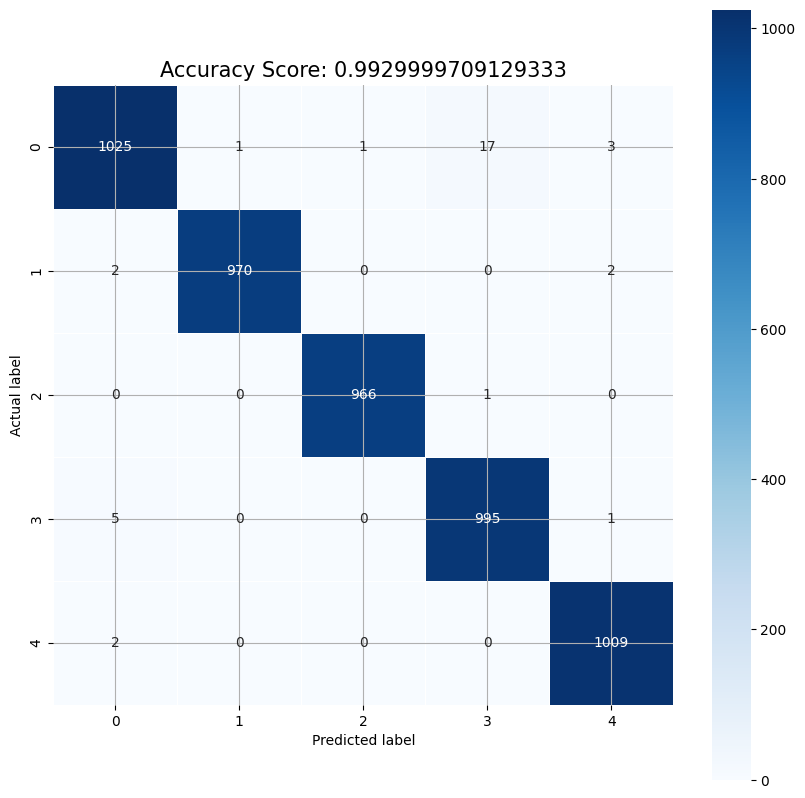

In [27]:
conf_matrix = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score[1])
plt.title(all_sample_title, size = 15);
plt.show()

In [28]:
# Lưu trọng số và cấu trúc mô hình vào file
model.save('ten_file_model.h5')